In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
import umap
import matplotlib.pyplot as plt
from adjustText import adjust_text

First, find which clinical parameters to use for UMAP between ADAS groups by performing Mann-Whitney U tests between ADAS groups to determine significance between groups

In [4]:
#load in the data
df_clinic = pd.read_excel('Supplementary Table 1.xlsx', sheet_name='Clinic_v1_raw')

In [5]:
# Exclude non-relevant columns for analysis
columns_to_keep = [col for col in df_clinic.columns if col not in ['Patient ID', 'ADAS-COG', 'ADAS group', 'Age', 'SEX', 'BMI', 'Cigarette']]
list_col = columns_to_keep

In [6]:
# Separate data into groups based on ADAS group
df_clinic_Low = df_clinic[df_clinic['ADAS group'] == 'Low']
df_clinic_Medium = df_clinic[df_clinic['ADAS group'] == 'Medium']
df_clinic_High = df_clinic[df_clinic['ADAS group'] == 'High']

In [7]:
# Convert relevant columns to numpy array
X_Low = df_clinic_Low[list_col].to_numpy()
X_Medium = df_clinic_Medium[list_col].to_numpy()
X_High = df_clinic_High[list_col].to_numpy()

In [8]:

# Initialize lists
log2fc = []
mw_stat = []
pvals = []

for i in range(len(list_col)):
    # Extract non-NaN values for low and medium groups
    temp1 = X_Low[:, i][~np.isnan(X_Low[:, i])]
    temp2 = X_Medium[:, i][~np.isnan(X_Medium[:, i])]
    
    # Calculate Log2 fold change
    log2fc.append(np.log2(np.mean(temp2) / np.mean(temp1)))
    
    # Perform Mann-Whitney U test
    s, p = mannwhitneyu(temp1, temp2)
    mw_stat.append(s)
    pvals.append(p)

# Compile results into a DataFrame
results_df = pd.DataFrame({
    'Log2FC': log2fc,
    'MW Stat': mw_stat,
    'p value': pvals
}, index=list_col)

# Filter significant results
results_df[results_df['p value'] < 0.05]

,Log2FC,MW Stat,p value
Platelet,-0.228544,608.0,0.025156
Albumin,-0.031322,577.0,0.046744
Triglycerides,-0.956022,693.0,0.000567
Insulin,-0.790098,529.0,0.043716


Platelet, Albumin, Triglycerides, and Insulin are significant parameters

In [16]:

# Initialize lists
log2fc = []
mw_stat = []
pvals = []

for i in range(len(list_col)):
    # Extract non-NaN values for low and high groups
    temp1 = X_Low[:, i][~np.isnan(X_Low[:, i])]
    temp2 = X_High[:, i][~np.isnan(X_High[:, i])]
    
    # Calculate Log2 fold change
    log2fc.append(np.log2(np.mean(temp2) / np.mean(temp1)))
    
    # Perform Mann-Whitney U tes
    s, p = mannwhitneyu(temp1, temp2)
    mw_stat.append(s)
    pvals.append(p)

# Compile results into a DataFrame
results_df = pd.DataFrame({
    'Log2FC': log2fc,
    'MW Stat': mw_stat,
    'p value': pvals
}, index=list_col)

# Filter significant results
results_df[results_df['p value'] < 0.05]

,Log2FC,MW Stat,p value
ALT,-0.302735,299.0,0.047710
Triglycerides,-0.982826,348.5,0.001263
Insulin,-0.687197,288.0,0.040137
HbA1c,-0.149101,290.5,0.034146


ALT and HbA1c are also significant

In [19]:
# Initialize lists
log2fc = []
mw_stat = []
pvals = []

for i in range(len(list_col)):
    # Extract non-NaN values for medium and high groups
    temp1 = X_Medium[:, i][~np.isnan(X_Medium[:, i])]
    temp2 = X_High[:, i][~np.isnan(X_High[:, i])]
    
    # Calculate Log2 fold change
    log2fc.append(np.log2(np.mean(temp2) / np.mean(temp1)))
    
    # Perform Mann-Whitney U tes
    s, p = mannwhitneyu(temp1, temp2)
    mw_stat.append(s)
    pvals.append(p)

# Compile results into a DataFrame
results_df = pd.DataFrame({
    'Log2FC': log2fc,
    'MW Stat': mw_stat,
    'p value': pvals
}, index=list_col)

# Filter significant results
results_df[results_df['p value'] < 0.05]

,Log2FC,MW Stat,p value


Next, plot the UMAP based on the selected significant parameters (Triglycerides, HbA1c, Insulin, ALT, Platelet, and Albumin.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


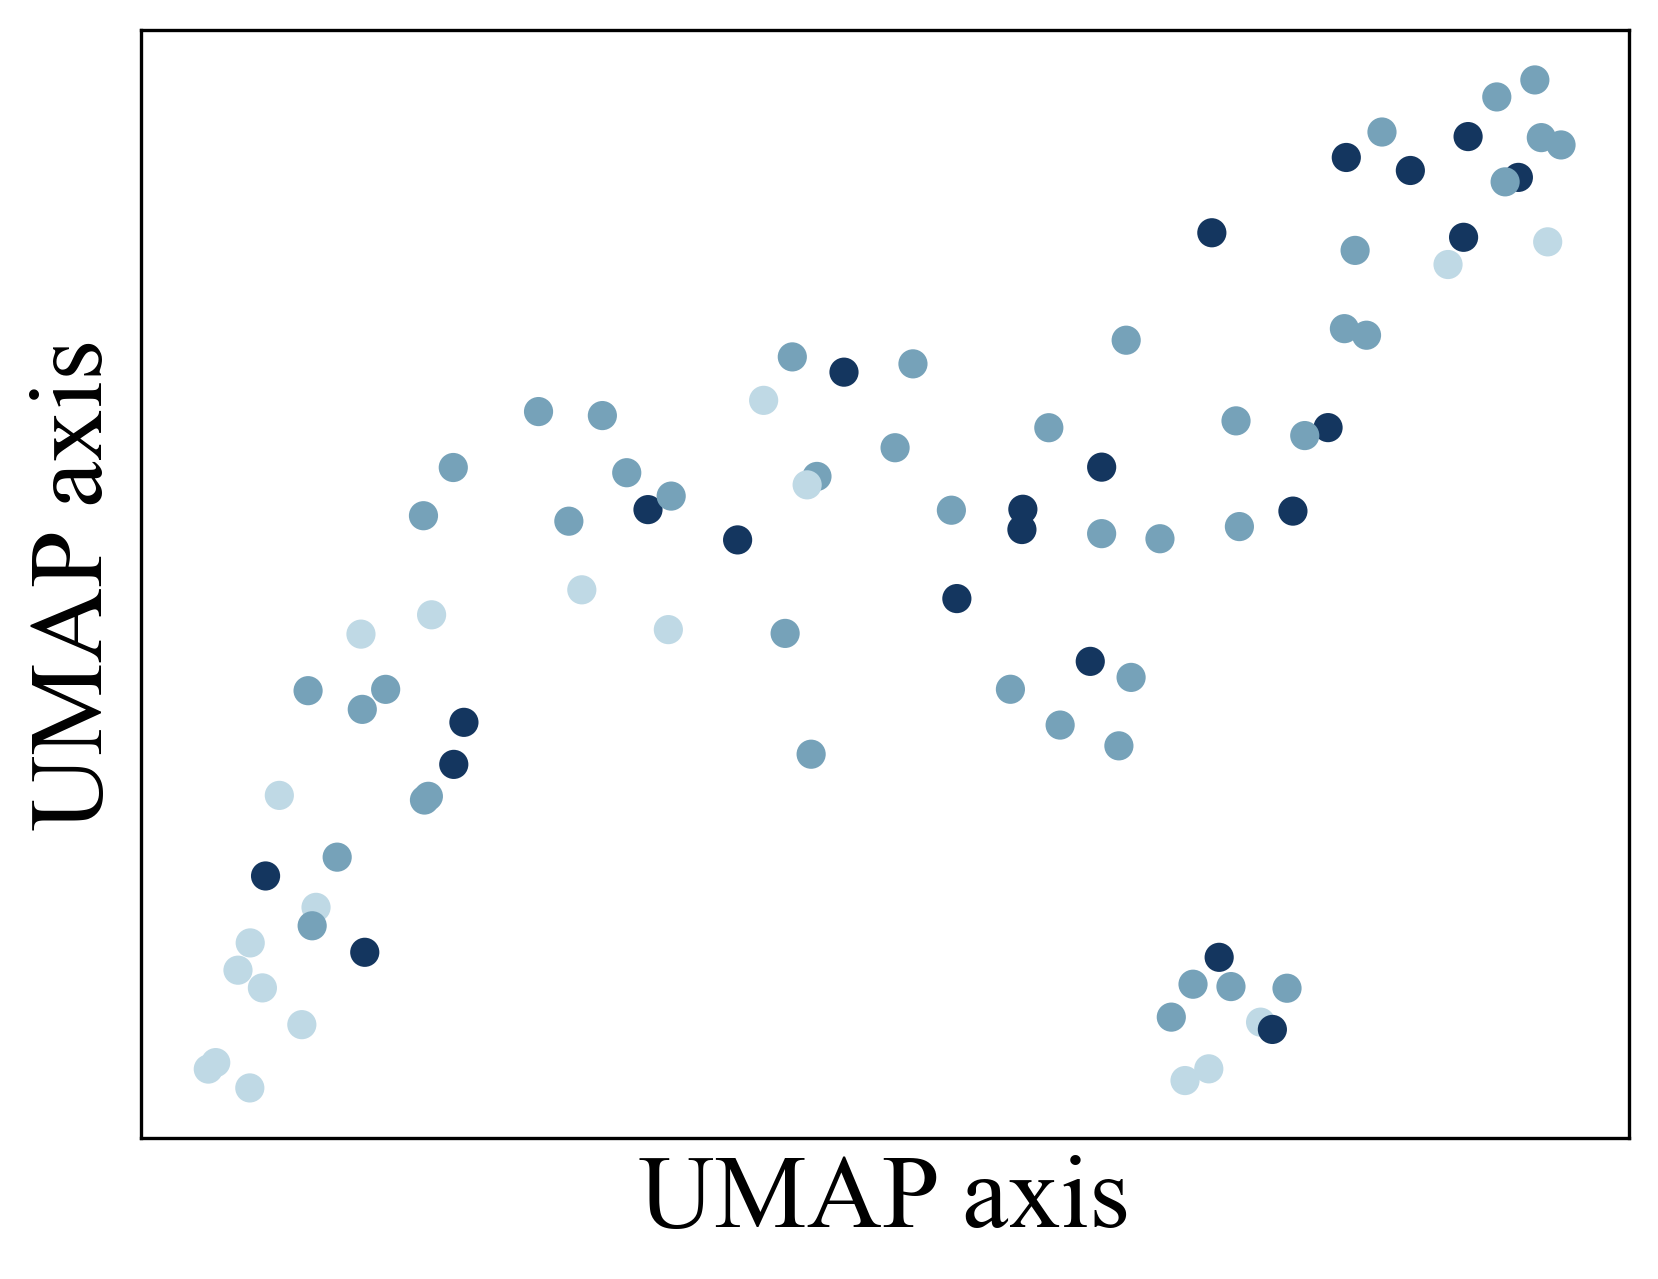

In [22]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 25})
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

df_clinic = pd.read_excel('Supplementary Table 1.xlsx', sheet_name='Clinic_v1_imputed')[[
    'ADAS group', 'Triglycerides', 'HbA1c', 'Insulin', 'ALT', 'Platelet', 'Albumin'
]]
label_color_map = {'Low': '#BFD9E5', 'Medium': '#76A2B9', 'High': '#14365F'}
colorset = [label_color_map[label] for label in list(df_clinic['ADAS group'])]

# create a UMAP model
model = umap.UMAP(n_neighbors=25, n_components=2, random_state=0)

# fit the model to the data
embedding = model.fit_transform(df_clinic.iloc[:,1:])

# plot the data
plt.scatter(embedding[:, 0], embedding[:, 1], c = colorset)
# Hide the tick marks
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP axis')
plt.ylabel('UMAP axis')
plt.show()

Next, create the volcano plot

In [24]:
"""Loads clinical and proteomics data. Then merges the two by adding ADAS group from clinical 
data to proteomics dataframe (returns this merged_df). ADAS group used to compare proteomics 
between different groups"""
df_clinic = pd.read_excel("Supplementary Table 1.xlsx", sheet_name='Clinic_v1_imputed')
df_proteomics = pd.read_excel("Supplementary Table 2.xlsx", sheet_name='Proteomics_v1')
df_merged = df_clinic.iloc[:, :2].merge(df_proteomics, on='Patient ID')

In [25]:
"""Process and split data into groups."""
genes = [col for col in df_merged.columns if col not in ['Patient ID', 'ADAS group']] #extract gene names from column names
#split into two data frames, where one contains only rows where ADAS = "Low" and the other where ADAS = "High"
df_low_adas = df_merged[df_merged['ADAS group'] == 'Low']
df_high_adas = df_merged[df_merged['ADAS group'] == 'High']
#Creates shorter names for use in volcano plot. Omits everything following "-"
gene_short = [gene.split('-')[0] for gene in genes]

In [26]:
"""Calculate log2FC, statistics, and p-values."""
#create lists to store statistics values
log2FC = []
kw_stat = []
pvals = []

for gene in genes:
    #compute log2 Fold Change
    fc = np.log2(np.average(2 ** df_high_adas[gene])) - np.log2(np.average(2 ** df_low_adas[gene]))
    log2FC.append(fc)

    # Perform Kruskal-Wallis test to determine if expression values differ between low and high adas groups
    t_stat, pval = stats.kruskal(2 ** df_high_adas[gene], 2 ** df_low_adas[gene])
    kw_stat.append(t_stat)
    pvals.append(pval)

#create df of results
df_results = pd.DataFrame({
    'Gene_name': gene_short,
    'log2FC': log2FC,
    'stat': kw_stat,
    'pvalue': pvals
})

# Compute significance levels
df_results['nlog10'] = -np.log10(df_results['pvalue']) #convert to -Log10 for better viewing
df_results['property'] = np.where(
    df_results['pvalue'] >= 0.05, 'no_significance',
    np.where(df_results['log2FC'] < 0, 'down_regulated', 'up_regulated')
)

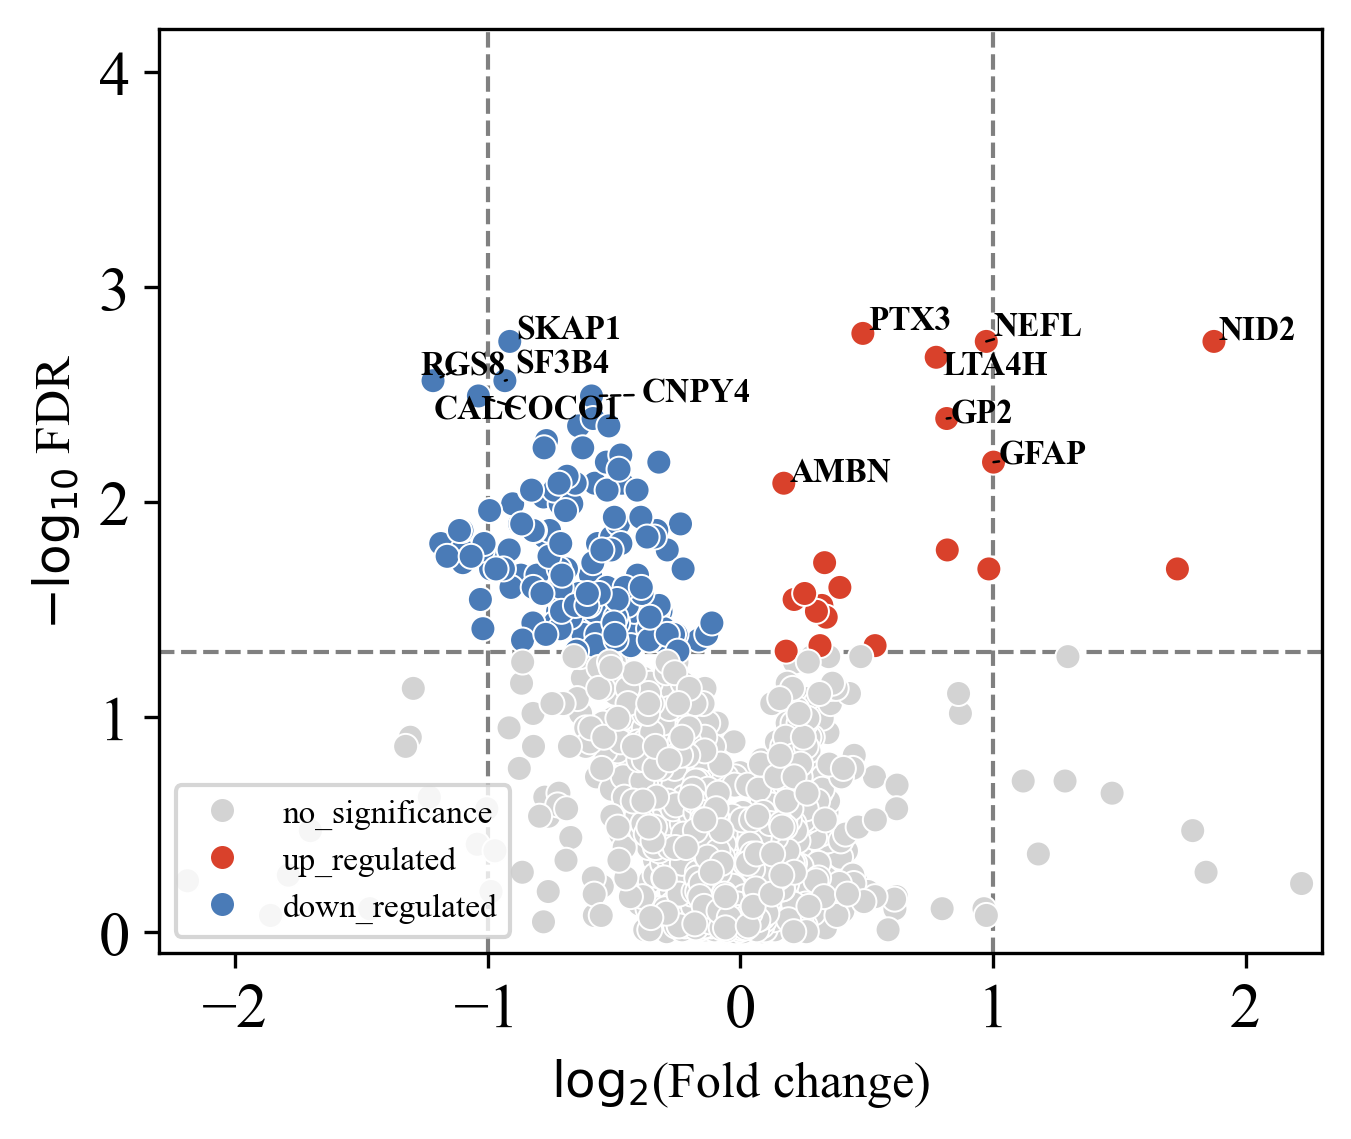

In [31]:
"""Plot the volcano plot."""

plt.rcParams['figure.figsize'] = [5.0, 4.0]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = "Times New Roman"

ax = sns.scatterplot(
    data=df_results, 
    x='log2FC', 
    y='nlog10', 
    hue='property', 
    hue_order=['no_significance', 'up_regulated', 'down_regulated'],
    palette=['lightgrey', '#D9412B', '#4A7BB7']
)

# Add reference lines
ax.axhline(-np.log10(0.05), zorder=0, c='grey', lw=1, ls='--')
ax.axvline(1, zorder=0, c='grey', lw=1, ls='--')
ax.axvline(-1, zorder=0, c='grey', lw=1, ls='--')

# Annotate significant points
texts = []
for _, row in df_results.iterrows():
    if row['nlog10'] > 2.4 and row['log2FC'] < 0:
        texts.append(plt.text(row['log2FC'], row['nlog10'], row['Gene_name'], fontsize=8, weight='bold'))
    if row['nlog10'] > 2 and row['log2FC'] > 0:
        texts.append(plt.text(row['log2FC'], row['nlog10'], row['Gene_name'], fontsize=8, weight='bold'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', ls='dashed', lw=0.6, color='k'))

# Add labels and limits
plt.xlabel(r"$\mathrm{log}_{2}$(Fold change)", size=12)
plt.ylabel(r"$-\mathrm{log}_{10}$ FDR", size=12)
plt.xlim(-2.3, 2.3)
plt.ylim(-0.1, 4.2)
plt.legend(fontsize=8, loc = "lower left")
plt.show()